# **Recomendador de Musica con Base de Datos de Spotify**

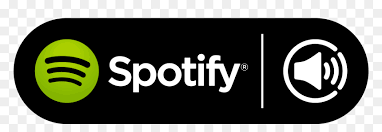

En esta notebook se realizará un motor de Recomendación de Canciones a partir de una base de datos pequeña de spotify.
Empezaré con un EDA para saber como utilizar el dataset. Luego ya que tenga entienda la base la ajustare al problema para que pueda ser mas facil de utilizarla.

# **Librerias**

In [1]:
pip install -r requeriments.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

from yellowbrick.target import FeatureCorrelation

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import difflib

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import json

import warnings
warnings.filterwarnings("ignore")

# **Leemos los Datos**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps # o pd
 
spark = SparkSession.builder.appName(
    'Spotify Recommender').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/09 06:28:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/09 06:28:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
data = spark.read.csv('data/data.csv', sep=',', inferSchema=True, header=True)
#genre_data = spark.read.csv('data/data_by_genres.csv', sep=',', inferSchema=True, header=True)
#year_data = spark.read.csv('data/data_by_year.csv', sep=',', inferSchema=True, header=True)

Se tienen 3 archivos csv que el primero llamado data.csv cuenta con 19 columnas, genre_data cuenta con 14 columnas y el ultimo cuenta con 14 columnas.

In [5]:
print(data.printSchema())

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)

None


In [6]:
print(data.show(10))

+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|           valence|year|acousticness|             artists|      danceability|duration_ms|             energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|            tempo|
+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|            0.0594|1921|       0.982|['Sergei Rachmani...|             0.279|     831667|              0.211|       0|4BJqT0PrAfrxzMOxy...|           0.878| 10|   0.665|            -20.0

In [7]:
#print(genre_data.printSchema())

In [8]:
#print(year_data.printSchema())

In [9]:
data.select('duration_ms','explicit','energy','popularity','danceability','instrumentalness','liveness','loudness').show(10)

+-----------+--------+-------------------+----------+------------------+----------------+--------+-------------------+
|duration_ms|explicit|             energy|popularity|      danceability|instrumentalness|liveness|           loudness|
+-----------+--------+-------------------+----------+------------------+----------------+--------+-------------------+
|     831667|       0|              0.211|         4|             0.279|           0.878|   0.665|            -20.096|
|     180533|       0|              0.341|         5|0.8190000000000001|             0.0|    0.16|            -12.441|
|     500062|       0|              0.166|         5|             0.328|           0.913|   0.101|             -14.85|
|     210000|       0|              0.309|         3|             0.275|        2.77e-05|   0.381|             -9.316|
|     166693|       0|              0.193|         2|             0.418|        1.68e-06|   0.229|            -10.096|
|     395076|       0|0.34600000000000003|      

In [10]:
#year_data.show(1)

In [11]:
data=data.withColumn("duration_ms",col("duration_ms").cast("double"))
data=data.withColumn("explicit",col("explicit").cast("double"))
data=data.withColumn("energy",col("energy").cast("double"))
data=data.withColumn("popularity",col("popularity").cast("double"))
data=data.withColumn("danceability",col("danceability").cast("double"))
data=data.withColumn("instrumentalness",col("instrumentalness").cast("double"))
data=data.withColumn("liveness",col("liveness").cast("double"))
data=data.withColumn("loudness",col("loudness").cast("double"))
data=data.na.fill(value=0)
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|release_date|speechiness|tempo|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|           0|          0|    0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+------------+-----------+-----+



# **Agrupación de canciones con K-Means**

In [12]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

%matplotlib inline

In [13]:
featuresUsed = ['duration_ms','explicit','energy','popularity','danceability','instrumentalness','liveness','loudness']
assembler = VectorAssembler(inputCols=featuresUsed,outputCol='features_unscaled')
assembled = assembler.transform(data)

In [14]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features_unscaled', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,12):

    KMeans_=KMeans(featuresCol='features_unscaled', k=K)

    KMeans_fit=KMeans_.fit(assembled)

    output_df=KMeans_fit.transform(assembled) 

    evaluation_score=evaluator.evaluate(output_df)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


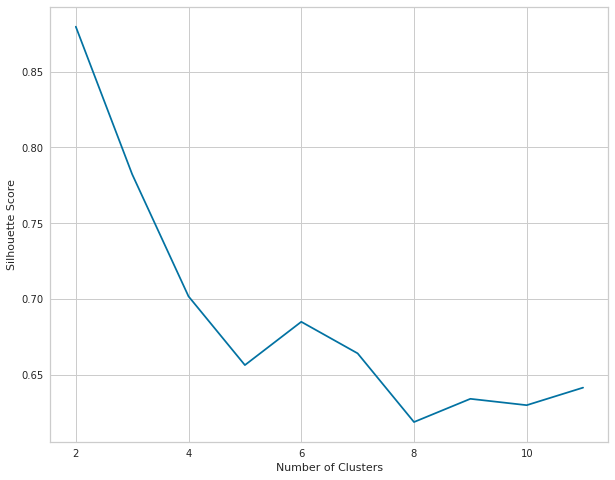

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,12),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [16]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features_unscaled", outputCol="pca")
pca_model = pca.fit(assembled)
pca_transformed = pca_model.transform(assembled)

22/05/09 06:29:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/05/09 06:29:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [17]:
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [18]:
cluster_assignment = np.array(output_df.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

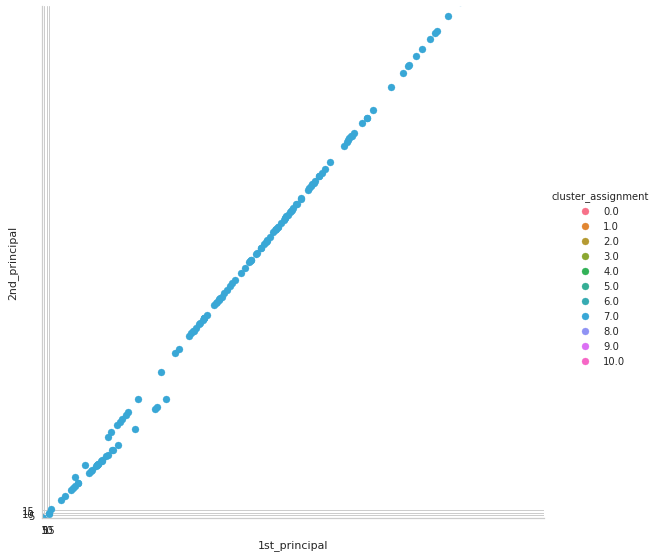

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
g=sns.FacetGrid(pca_df,hue="cluster_assignment", height=8).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
g.set(xlim=(0, 1000), ylim=(0, 1000), xticks=[5, 10, 15], yticks=[5, 10, 15])
plt.show()

In [20]:
output_df.select('name','year','prediction').show(10)

+--------------------+----+----------+
|                name|year|prediction|
+--------------------+----+----------+
|Piano Concerto No...|1921|         2|
|Clancy Lowered th...|1921|         1|
|           Gati Bali|1921|         3|
|           Danny Boy|1921|         1|
|When Irish Eyes A...|1921|         6|
|        Gati Mardika|1921|         8|
|The Wearing of th...|1921|         6|
|Morceaux de fanta...|1921|         9|
|La Mañanita - Rem...|1921|         6|
|   Il Etait Syndiqué|1921|         1|
+--------------------+----+----------+
only showing top 10 rows



In [21]:
psdf = output_df.toPandas()

In [23]:
psdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   valence            170653 non-null  float64
 1   year               170653 non-null  int32  
 2   acousticness       170653 non-null  float64
 3   artists            170653 non-null  object 
 4   danceability       170653 non-null  float64
 5   duration_ms        170653 non-null  float64
 6   energy             170653 non-null  float64
 7   explicit           170653 non-null  float64
 8   id                 170653 non-null  object 
 9   instrumentalness   170653 non-null  float64
 10  key                170653 non-null  object 
 11  liveness           170653 non-null  float64
 12  loudness           170653 non-null  float64
 13  mode               170653 non-null  object 
 14  name               170653 non-null  object 
 15  popularity         170653 non-null  float64
 16  re

In [24]:
from sklearn.preprocessing import StandardScaler

# **Construcción del Motor de recomendación**

* Según el análisis y las visualizaciones, está claro que los géneros similares tienden a tener puntos de datos que se ubican cerca unos de otros, mientras que los tipos de canciones similares también se agrupan.
* Esta observación tiene mucho sentido. Los géneros similares sonarán de manera similar y provendrán de períodos de tiempo similares, mientras que lo mismo puede decirse de las canciones dentro de esos géneros. Podemos usar esta idea para construir un sistema de recomendación tomando los puntos de datos de las canciones que un usuario ha escuchado y recomendando canciones correspondientes a puntos de datos cercanos.
* [Spotipy](https://spotipy.readthedocs.io/en/2.16.1/) es un cliente de Python para la API web de Spotify que facilita a los desarrolladores la obtención de datos y la consulta de canciones en el catálogo de Spotify. Tienes que instalar usando `pip install spotipy`
* Después de instalar Spotipy, deberá crear una aplicación en la [página del desarrollador de Spotify] (https://developer.spotify.com/) y guardar su ID de cliente y clave secreta.

In [29]:
from sklearn.cluster import KMeans
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)

In [40]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="62cfe79d83ef43c69a7ba63f9f5debda",
                                                           client_secret="88e6707695634f04a75301fcc77d7789"))

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None
    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    
    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]
    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)



In [41]:
featuresUsed = ['duration_ms','explicit','energy','popularity','danceability','instrumentalness','liveness','loudness']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[featuresUsed].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs(song_list, spotify_data, n_songs=5):
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    X = psdf[featuresUsed]
    number_cols = list(X.columns)
    song_cluster_pipeline.fit(X)
    song_cluster_labels = song_cluster_pipeline.predict(X)
    psdf['cluster_label'] = song_cluster_labels
    scaled_data = scaler.transform(spotify_data[featuresUsed])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')
 

In [45]:
recommend_songs([{'name': 'The Trooper', 'year':1991},
                {'name': 'Strutter', 'year':1974},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Numb', 'year': 2002}],  psdf)

Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache


[{'name': 'All Alone',
  'year': 2005,
  'artists': "['Gorillaz', 'Roots Manuva']"},
 {'name': 'No Sé Vivir Sin Ti', 'year': 2002, 'artists': "['Los Temerarios']"},
 {'name': 'Closer', 'year': 2013, 'artists': "['Tegan and Sara']"},
 {'name': 'A Woman Like You', 'year': 2012, 'artists': "['Lee Brice']"},
 {'name': "It Ain't Me Babe", 'year': 1964, 'artists': "['Bob Dylan']"}]

In [46]:
recommend_songs([{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}],  psdf)

Couldn't read cache at: .cache
Couldn't write token to cache at: .cache
Couldn't read cache at: .cache
Couldn't write token to cache at: .cache


[{'name': 'Street Of Dreams', 'year': 1983, 'artists': "['Rainbow']"},
 {'name': 'Strawberry Wine', 'year': 1996, 'artists': "['Deana Carter']"},
 {'name': 'Fight the Feeling',
  'year': 2012,
  'artists': "['Mac Miller', 'Kendrick Lamar', 'Iman Omari']"},
 {'name': 'Coleccionista de Canciones', 'year': 2006, 'artists': "['Camila']"},
 {'name': 'White Christmas - Remastered',
  'year': 2000,
  'artists': "['Booker Ervin']"}]

* Esta última celda te dará una lista de recomendación de canciones

* Puedes cambiar la lista de canciones según tu elección.